In [18]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
from mltrainer import Trainer, TrainerSettings, ReportTypes
import tomllib
import seaborn as sns
import numpy as np
from torch import Tensor
import math
from typing import List, Tuple, Dict, Any, Union
from src import datasets, metrics
import mltrainer
import mlflow
from src import models
import torch.nn.functional as F
from torchsummary import summary


mltrainer.__version__

'0.1.129'

In [17]:
confusion_matrixs = {}

In [3]:

def test_model(model, teststreamer):
    y_true = []
    y_pred = []
    #model = model.to("cpu")

    #testdata = [(x.to(device), y.to(device)) for x, y in teststreamer.stream()]
    testdata = teststreamer.stream()
    for _ in range(len(teststreamer)):
        X, y = next(testdata)

        yhat = model(X)
        yhat = yhat.argmax(dim=1) # we get the one with the highest probability
        y_pred.append(yhat.cpu().tolist())
        y_true.append(y.cpu().tolist())

    yhat = [x for y in y_pred for x in y]
    y = [x for y in y_true for x in y]
    return y, yhat

def plot_confusion_matrix(cfm, model_name):
    # Create the plot using seaborn
    plot = sns.heatmap(cfm, annot=True, fmt=".3f")
    
    # Set the labels for the axes
    plot.set(xlabel="Predicted", ylabel="Target")
    
    # Save the plot to a file with the model name in the filename
    plt.savefig(f"{model_name}_confusion_matrix.png", bbox_inches="tight")
    
    # Optionally, display the plot
    plt.show()

# difference between test and train
def calculate_difference(train_scores_str, test_scores_str):
    # Remove the brackets and split the string by spaces
    str_list = test_scores_str.strip('[]').split()

    # Convert each element to a float
    test_scores_str = [float(num) for num in str_list]

    test_scores = [float(x) for x in test_scores_str]
    train_scores = [float(x) for x in train_scores_str]
    difference = [str(np.round(test - train, 3)) for test, train in zip(test_scores, train_scores)]
    print(f'train loss average:{np.round(np.mean(test_scores), 3)}')
    print(f'test loss average:{np.round(np.mean(test_scores), 3)}')

    return difference



In [6]:
def train_model(trainstreamer, teststreamer, config, settings=None):

        loss_fn = torch.nn.CrossEntropyLoss()

        with mlflow.start_run():
            optimizer = torch.optim.Adam

            if settings==None:
                # default settings
                settings = TrainerSettings(
                    epochs=15,
                    metrics=[accuracy, f1micro, f1macro, precision, recall],
                    logdir="logs/heart2D_oversampled",
                    train_steps=len(trainstreamer) // 5,
                    valid_steps=len(teststreamer) // 5,
                    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
                    scheduler_kwargs={"factor": 0.5, "patience": 2},
                    earlystop_kwargs={"patience": 8},
                )
            if config['traindataset'] =='smote':
                    settings.logdir="logs/heart2D_smote",

            trainer = Trainer(
                model=model,
                settings=settings,
                loss_fn=loss_fn,
                optimizer=optimizer,
                traindataloader=trainstreamer.stream(),
                validdataloader=teststreamer.stream(),
                scheduler= config["scheduler"],
            )

            mlflow.set_tag("model", config["model"])
            mlflow.set_tag("dataset", "heart_big_oversampled")
            mlflow.log_param("scheduler", str(trainer.scheduler).split(".")[-1])
            mlflow.log_param("earlystop", str(settings.earlystop_kwargs))

            base_config = {
                "hidden": config["hidden"],
                "dropout": config["dropout"],
                "num_classes": config["num_classes"],
                "num_heads": config["num_heads"],
                "num_blocks": config["num_blocks"],
                "shape": config["shape"],
  
            }
            mlflow.log_params(base_config)
            mlflow.log_param("epochs", settings.epochs)
            mlflow.log_param("shape0", config["shape"])
            mlflow.log_param("optimizer", str(optimizer))
            mlflow.log_params(settings.optimizer_kwargs)
            trainer.loop()



In [10]:
datadir = Path('../data/processed')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

if torch.backends.mps.is_available():
            device = torch.device('mps')
            print('MPS is available')
else:
            device = torch.device('cpu')

{'ptb': 'heart', 'arrhythmia': 'heart_big'}
MPS is available


In [11]:
#choos dataset
trainfile = datadir / (config['arrhythmia'] + '_oversampled_full_train.parq')
#trainfile = datadir / (config['arrhythmia'] + '_SMOTE_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')

trainfile, testfile


(PosixPath('../data/processed/heart_big_oversampled_full_train.parq'),
 PosixPath('../data/processed/heart_big_test.parq'))

## Test 2D models

In [12]:
# load 2D dataset with shape = (16, 12)
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset

(Heartdataset2D (#275000), Heartdataset2D (#21892))

In [13]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(8593, 684)

In [15]:
#load settings
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

settings = TrainerSettings(
        epochs=30,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D_oversampled",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.2, "patience": 2},
        earlystop_kwargs= {"patience": 15},
        device= device
    )

# Model: 2D CNN

In [16]:
modelname= "CNN2D"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 3,
    "dropout": 0.3,
    "num_classes": 5,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
    "num_heads": 0,
    "traindataset": "oversampled",
    
}
if 'smote' in str(trainfile):
    config['traindataset'] = 'smote'



print(config)
model = models.CNN(config)
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)


2025-02-04 18:09:29.243 | INFO     | src.models:__init__:116 - Activation map size: 48
2025-02-04 18:09:29.243 | INFO     | src.models:__init__:117 - Input linear: 6144


{'model': 'CNN2D', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 3, 'dropout': 0.3, 'num_classes': 5, 'num_blocks': 1, 'shape': (16, 12), 'num_heads': 0, 'traindataset': 'oversampled'}


2025-02-04 18:09:29.487 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D_oversampled/20250204-180929
2025-02-04 18:09:29.864 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 1718/1718 [02:05<00:00, 13.65it/s]
2025-02-04 18:11:40.261 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3225 test 0.3038 metric ['0.8888', '0.8888', '0.6782', '0.8888', '0.9180']
100%|██████████| 1718/1718 [02:13<00:00, 12.90it/s]
2025-02-04 18:13:57.906 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1119 test 0.2182 metric ['0.9301', '0.9301', '0.7422', '0.9301', '0.9384']
100%|██████████| 1718/1718 [02:13<00:00, 12.83it/s]
2025-02-04 18:16:16.304 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.0783 test 0.1730 metric ['0.9478', '0.9478', '0.8083', '0.9478', '0.9528']
100%|██████████| 1718/1718 [02:15<00:00, 12.66it/s]
2025-02-04 18:18:36.430 | INFO     | 

TypeError: 'dict' object is not callable

{'model': 'CNN2D', 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'input': 1, 'hidden': 128, 'num_layers': 3, 'dropout': 0.3, 'num_classes': 5, 'num_blocks': 1, 'shape': (16, 12), 'num_heads': 0, 'traindataset': 'oversampled'}


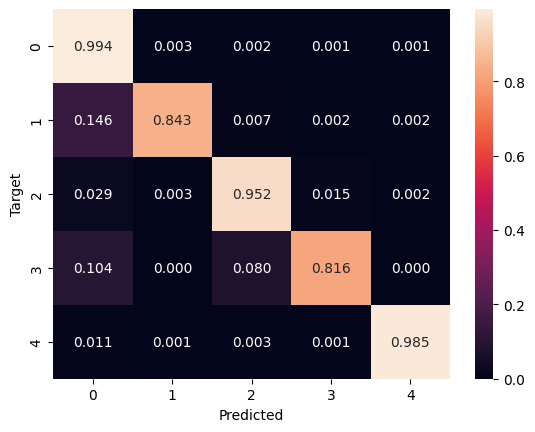

In [19]:
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)

# MODEL 2CNN WITH RESNET BLOCK

Hypothesis:
Resnet block would help the CNN to avoid overfitting the data
ResNet block consists of two convolutions with batch normalization, ReLU activation, and a skip connection that adds the input back to the output.
Hypthesis: the ResNet block would help with longer training, supporting the gradient and learning of more complex representations.
2D CNN: Good at extracting local spatial features from the data (like images or spatial sequences).

In [ ]:
modelname= "CNN2DResNet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
    'traindataset': 'oversampled'
}
if 'smote' in str(trainfile):
    config['traindataset'] = 'smote'

print(config)
model = models.CNN2DResNet(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)

# TRANSFORMER MODELS

## TRANSFORMER 2D

Changed Transformer with 1D cnn to Transformer with 2D CNN
Because the Transformer with 1D CNN is performing below expectation, 2D CNN might help the learning of features in minority classes


In [ ]:
modelname= "Transformer2D"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "input": 1,
    "hidden": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
    'traindataset': 'oversampled'
   
}
if 'smote' in str(trainfile):
    config['traindataset'] = 'smote'

print(config)
model = models.Transformer2D(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)

# MODEL TRANSFORMER 2D WITH RESNET BLOCK
Adding a ResNet block to a Transformer has several advantages:

Improved gradient flow, leading to more stable training and easier optimization.
The model can learn richer and more complex features.
Better regularization and reduced risk of overfitting.
Reduced training time, scale up models without degrading performance.

In [ ]:
modelname= "Transformer2DResNet"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
    'traindataset': 'oversampled'
   
}
if 'smote' in str(trainfile):
    config['traindataset'] = 'smote'
    
print(config)
model = models.Transformer2DResNet(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)

# MODEL TRANSFORMER WITH SQUEEZE AND EXCITE BLOCK

Squeeze-and-Excitation (SE) block: 
Squeeze: It computes global statistics (e.g., global average pooling) across the feature maps, summarizing the channel-wise information into a compact representation.
Excite: The resulting compact representation is passed through a small fully connected network (usually with activation functions like ReLU and Sigmoid) to generate channel-wise attention weights that modify (recalibrate) the original feature map.

In a Transformer: Adding SE blocks to a Transformer can help recalibrate the features extracted by the attention mechanism. Specifically, each channel (or attention head) can learn to focus on more important features while suppressing less important ones. 


In [ ]:

modelname= "Transformer2DResNetSE"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
    'traindataset': 'oversampled'
   
}
if 'smote' in str(trainfile):
    config['traindataset'] = 'smote'
    
print(config)
model = models.Transformer2DResNetSE(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
confusion_matrixs[modelname] = cfm

print(config)
plot_confusion_matrix(cfm, modelname)plot_confusion_matrix(cfm)


## TRANSFORMER + CNN 2D + RESNET + SE + MULTIHEAD

IDEA:
Conv2D: Extracts low-level spatial features.
ResNet block: Enables deep learning via residual connections.
Squeeze-and-Excite: Recalibrates feature maps to emphasize important channels.
Positional Encoding: Adds positional information to the sequence for the transformer.
Transformer Blocks: Captures long-range dependencies and complex relationships.
Global Pooling: Reduces the sequence output to a fixed-size representation.
Multi head attention: This mechanism allows the model to focus on different parts of the sequence simultaneously, learning multiple relationships between the features.

In [ ]:

modelname= "Transformer2DResNetWithAttention"
config = {
    "model": modelname,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "hidden": 128,
    "dropout": 0.2,
    "num_classes": 5,
    "num_heads": 8,
    "num_blocks": 1,
    "num_classes": 5,
    "shape": (16, 12),
    'traindataset': 'oversampled'
   
}
if 'smote' in str(trainfile):
    config['traindataset'] = 'smote'
print(config)
model = models.Transformer2DResNetWithAttention(config)
print(model)

mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment(config["model"])
train_model(trainstreamer, teststreamer, config, settings)
y, yhat = test_model(model, teststreamer)
cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)
confusion_matrixs[modelname] = cfm
print(config)
plot_confusion_matrix(cfm, modelname)